In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# ÂÆö‰πâÂõ†Â≠êÔºÅ

In [ ]:
def volatility_adjusted_smart_money(df, window=60, atr_period=14, rsi_window=14):
    """
    Âü∫‰∫éÊ≥¢Âä®ÊÄßÁöÑËÅ™ÊòéÈí±Âõ†Â≠ê
    - ‰ΩøÁî®ATRË∞ÉÊï¥ËÅ™ÊòéÈí±ÊïàÂ∫îÔºåÈÄÇÂ∫î‰∏çÂêåÊ≥¢Âä®ÊÄßÁéØÂ¢É
    """
    close = df['close']
    price_diff = close.diff()
    
    taker_ratio = df['taker_buy_volume'] / df['volume'].replace(0, 1e-12)
    
    gain = (price_diff * taker_ratio).where(price_diff > 0, 0)
    loss = (-price_diff * (1 - taker_ratio)).where(price_diff < 0, 0)
    
    sum_gain = gain.rolling(window).sum()
    sum_loss = loss.rolling(window).sum()
    
    # Ê≥¢Âä®ÊÄßË∞ÉÊï¥ÔºöÈÅøÂÖçÈô§‰ª•Èõ∂
    atr = ta.atr(df['high'], df['low'], close, length=atr_period)
    
    # ËÆ°ÁÆóRSI
    df['rsi'] = ta.rsi(df['close'], length=rsi_window)
    
    # ËØÜÂà´Ë∂Ö‰π∞Âå∫ÂüüÔºàRSI>70Ôºâ
    overbought = np.where(df['rsi'] > 70, 1.5, 0.5)
    
    max_open_close = np.maximum(df['open'], df['close'])
    upper_shadow = df['high'] - max_open_close
    base_kup1 = upper_shadow / df['open']

    factor_1 = abs(base_kup1 * overbought * df['volume'].diff())

    volatility_adjustment = atr.rolling(window).mean() + 1e-12
    factor_2 = (sum_gain - sum_loss) / volatility_adjustment

    factor_composite = factor_1 * factor_2

    # ‰ΩøÁî®ÊªöÂä®Á™óÂè£ËÆ°ÁÆóÂä®ÊÄÅÈòàÂÄº
    rolling_quantile = factor_composite.quantile(0.15)
    rolling_std = factor_composite.std()
    
    # Â∞æÈÉ®‰ø°Âè∑ËØÜÂà´‰∏éÂº∫Âåñ
    tail_condition = factor_composite < rolling_quantile
    enhanced_factor = np.where(
        tail_condition,
        factor_composite - 2 * rolling_std,
        factor_composite
    )

    return enhanced_factor

# Âõ†Â≠êÊµãËØï

In [13]:
evaluator.set_factor(
    factor_func=volatility_adjusted_smart_money,
    factor_name='volatility_adjusted_smart_money'
)


üìä ÂçïÂ∏ÅÁßç (single) ËØ¶ÁªÜËØÑ‰º∞ÁªìÊûú:
--------------------------------------------------
üîó Áõ∏ÂÖ≥ÊÄßÂàÜÊûê:
   IC (Pearson): 0.004171
   Rank_IC (Spearman): -0.023395
üìä ‰ø°ÊÅØÊØîÁéá:
   IR: -0.357037
   ÊúâÊïàÂàÜÁªÑÊï∞: 10
üìä Âõ†Â≠êÂàÜÂ∏É:
üìã Êï∞ÊçÆÊ¶ÇÂÜµ:
   Êï∞ÊçÆÈïøÂ∫¶: 130738
   Âõ†Â≠êÂàó: volatility_adjusted_smart_money
   Êî∂ÁõäÁéáÂàó: future_return
   Êú™Êù•Êî∂ÁõäÂë®Êúü: 10
--------------------------------------------------

üñºÔ∏è  ÂçïÂ∏ÅÁßç (single) ÂõæÁâáÂ±ïÁ§∫:
----------------------------------------
üìä ÊòæÁ§∫ÂàÜÁªÑÂàÜÊûêÂõæ...


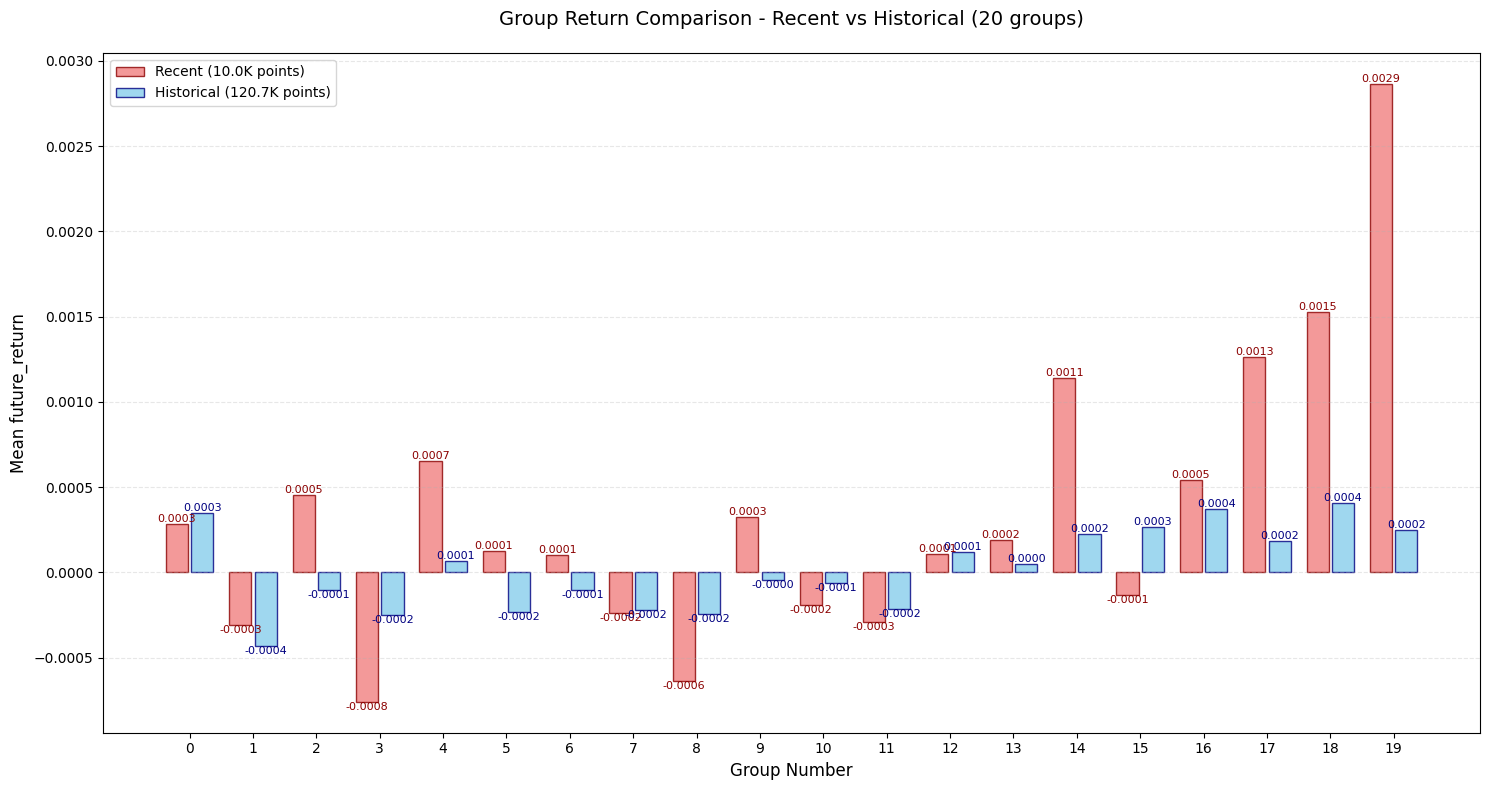

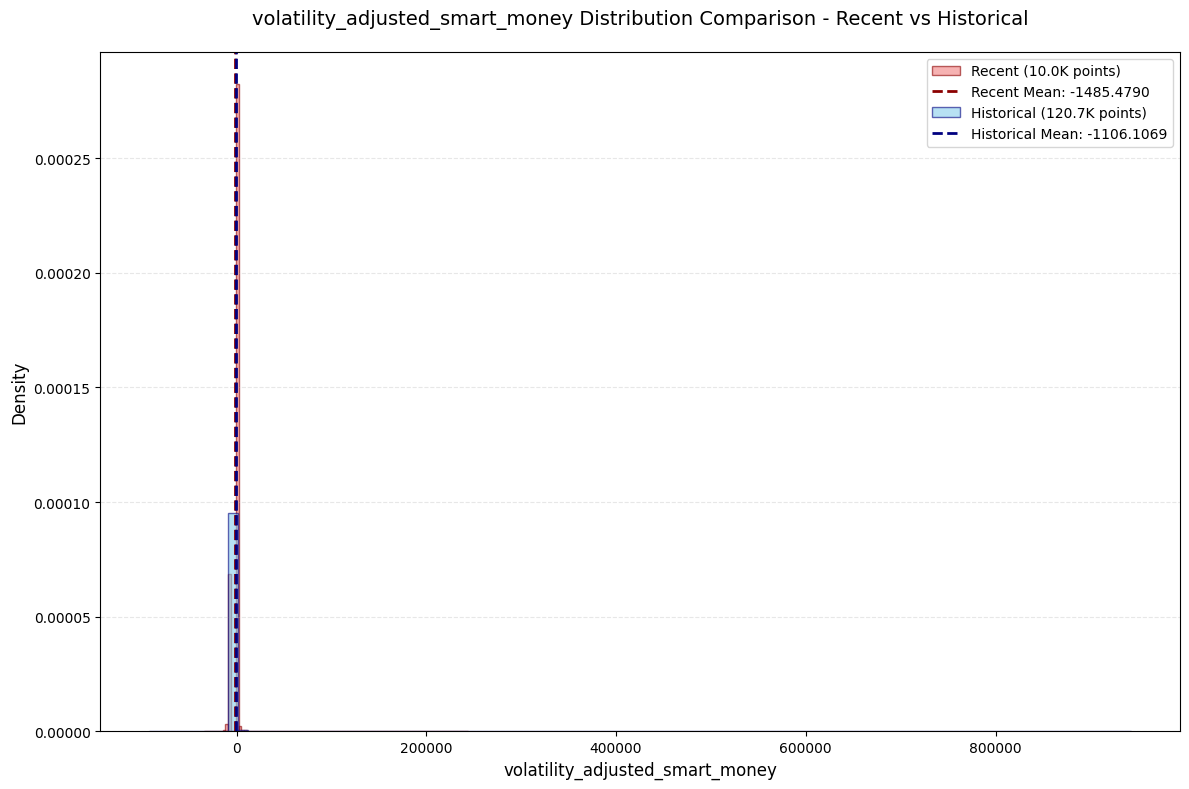

üìà ÊòæÁ§∫Âõ†Â≠êÂàÜÂ∏ÉÂõæ...
‚úÖ Â∑≤ÊòæÁ§∫ 2 ‰∏™ÂõæÁâá
----------------------------------------


In [14]:
result=evaluator.run_full_evaluation(run_stationarity_test=False)

In [15]:
print(result)

{'correlation_analysis': {'IC': 0.004170733151892047, 'Rank_IC': -0.023395365370076443}, 'information_ratio': {'IR': -0.3570367744164675, 'group_correlations': [-0.02778257502866977, -0.0013833601917532128, -0.018513754793420947, -0.012649543616533946, 0.011452487938139785, -0.0050377472091044165, 0.0032926675419759615, 0.008321794467362179, -0.008327527960631813, 0.007569107241382028], 'n_groups': 10}, 'group_analysis': {'group_stats':           val_min     val_max   val_mean  return_mean  return_std  count
group                                                                   
0     -91923.0797  -8170.5652 -8663.7076       0.0004      0.0197   6537
1      -8170.5463  -8115.6841 -8136.4847      -0.0004      0.0147   6537
2      -8115.6813  -8099.7740 -8106.4840      -0.0002      0.0138   6537
3        -13.7410     -7.0221    -9.9612      -0.0002      0.0118   6537
4         -7.0215     -3.6859    -5.1606       0.0000      0.0111   6537
5         -3.6855     -1.8812    -2.7038      -0